In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

This notebook selects the dimension and preprocess all the data into trainable values. 

## 1. Loading dataset

In [2]:
dataset_df = pd.read_csv('../data/NREL_All_Stations_data.csv', delimiter='\t')
print('Dataset shape: ', dataset_df.shape)

Dataset shape:  (67622, 74)


/tmp/ipykernel_12107/2013003107.py:1: DtypeWarning: Columns (6,20,31,46,69,73) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_df = pd.read_csv('../data/NREL_All_Stations_data.csv', delimiter='\t')


The dataset contains 67622 rows and 28 columns. The top 5 rows are shown below.

## 2. Exploratory Data Analysis

First, we delete the columns that are not useful for our analysis. 

In [32]:
core_params = [
    'Cards Accepted', 'EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count',
    'EV Network', 'Owner Type Code',
    'EV Connector Types', 'Restricted Access', 'Facility Type',
    'EV Pricing', 'EV On-Site Renewable Source', 
    'Maximum Vehicle Class', 'EV Workplace Charging', 'Latitude', 'Longitude',
]
dataset_df = dataset_df[core_params]

Then, we check the basic distribution of the data.

In [33]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67622 entries, 0 to 67621
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Cards Accepted               5357 non-null   object 
 1   EV Level1 EVSE Num           727 non-null    float64
 2   EV Level2 EVSE Num           59253 non-null  float64
 3   EV DC Fast Count             9238 non-null   float64
 4   EV Network                   67619 non-null  object 
 5   Owner Type Code              18236 non-null  object 
 6   EV Connector Types           67585 non-null  object 
 7   Restricted Access            10433 non-null  object 
 8   Facility Type                17338 non-null  object 
 9   EV Pricing                   13797 non-null  object 
 10  EV On-Site Renewable Source  416 non-null    object 
 11  Maximum Vehicle Class        10359 non-null  object 
 12  EV Workplace Charging        67612 non-null  object 
 13  Latitude        

In [34]:
dataset_df.describe()

,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,Latitude,Longitude
count,727.000000,59253.000000,9238.000000,67622.000000,67622.000000
mean,4.444292,2.371087,4.059104,37.749384,-96.834435
std,9.528520,3.132578,4.962888,5.066056,19.562725
min,1.000000,1.000000,1.000000,0.000000,-164.848855
25%,1.000000,2.000000,1.000000,34.027712,-118.016642
50%,2.000000,2.000000,2.000000,38.397025,-93.224228
75%,3.000000,2.000000,6.000000,41.402666,-79.047833
max,121.000000,338.000000,84.000000,64.852466,122.373276


## 3. Feature Engineering

First, we categorize the types of features into 3 groups: numerical, categorical, and boolean.

In [35]:
num_attribs = dataset_df.select_dtypes('number').columns.to_list()
cat_attribs = dataset_df.select_dtypes('object').columns.to_list()
bool_attribs = dataset_df.select_dtypes('bool').columns.to_list()
print('Numerical attributes: ', num_attribs)
print('Categorical attributes: ', cat_attribs)
print('Boolean attributes: ', bool_attribs)

Numerical attributes:  ['EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count', 'Latitude', 'Longitude']
Categorical attributes:  ['Cards Accepted', 'EV Network', 'Owner Type Code', 'EV Connector Types', 'Restricted Access', 'Facility Type', 'EV Pricing', 'EV On-Site Renewable Source', 'Maximum Vehicle Class', 'EV Workplace Charging']
Boolean attributes:  []


Convert boolean attributes into integers.

In [36]:
for bool_attrib in bool_attribs:
    dataset_df[bool_attrib] = dataset_df[bool_attrib].astype('int64')
dataset_df['Restricted Access'] = dataset_df['Restricted Access'].apply(lambda x: 1 if x == True else 0)
dataset_df['EV Workplace Charging'] = dataset_df['EV Workplace Charging'].apply(lambda x: 1 if x == True else 0)

Define functions to retrieve price information from the texts. 

In [37]:
def get_park_price(x):
    x = str(x)
    if str(x).lower() == 'free':
        return 0
    # Extract hourly rate
    hourly_rate = re.findall(r'(\$\d+\.?\d*)-(\$\d+\.?\d*)/Hr \w+ Parking Fee', x)
    if not hourly_rate:
        hourly_rate = re.findall(r'(\$\d+\.?\d*)/Hr Parking Fee', x)
    if not hourly_rate:
        hourly_rate = re.findall(r'(\$\d+\.?\d*) per hour', x)
    if not hourly_rate:
        hourly_rate = re.findall(r'(\$\d+\.?\d*) per minute', x)
        hourly_rate = re.findall(r'\d+\.?\d*', str(hourly_rate))
        hourly_rate = [float(rate) * 60 for rate in hourly_rate]
    # Convert to float if hourly_rate is found else return None
    hourly_rate = re.findall(r'\d+\.?\d*', str(hourly_rate))
    for i in range(len(hourly_rate)):
        hourly_rate[i] = float(hourly_rate[i])
    if hourly_rate:
        return np.mean(hourly_rate)
    else:
        return 0
    
def get_electric_price(x):
    x = str(x)
    if x.lower() == 'free':
        return 0
    # Extract hourly rate
    rate = re.findall(r'(\$\d+\.?\d*)-(\$\d+\.?\d*)/kWh \w+ Energy Fee', x)
    if not rate:
        rate = re.findall(r'(\$\d+\.?\d*)/kWh Energy Fee', x)
    if not rate:
        rate = re.findall(r'(\$\d+\.?\d*) per kWh', x)
    # Convert to float if rate is found else return None
    rate = re.findall(r'\d+\.?\d*', str(rate))
    for i in range(len(rate)):
        rate[i] = float(rate[i])
    if rate:
        return np.mean(rate)
    else:
        return 0
                     

Verify the functions with the top 10 items with the highest appearance frequency.

In [38]:
first_10 = dataset_df['EV Pricing'].value_counts().index[:10]
for item in first_10:
    print(item, get_park_price(item), get_electric_price(item))

Free 0 0
FREE 0 0
$2.00/Hr Parking Fee 2.0 0
Pricing unknown 0 0
$1.00/Hr Parking Fee 1.0 0
$0.38 per kWh 0 0.38
$0.30 per kWh 0 0.3
$1.50/Hr Parking Fee 1.5 0
$0.00-$5.00/Hr Variable Parking Fee 2.5 0
$1.35/Hr Parking Fee 1.35 0


Apply the function to the data and get two columns for parking price and electricity price.

In [39]:
dataset_df['Park Pricing'] = dataset_df['EV Pricing'].apply(get_park_price)
dataset_df['Electric Pricing'] = dataset_df['EV Pricing'].apply(get_electric_price)
dataset_df.drop('EV Pricing', axis=1, inplace=True)

Then, we deal with the numerical features. The histogram of the numerical features are shown below.

<Axes: xlabel='EV DC Fast Count', ylabel='Count'>

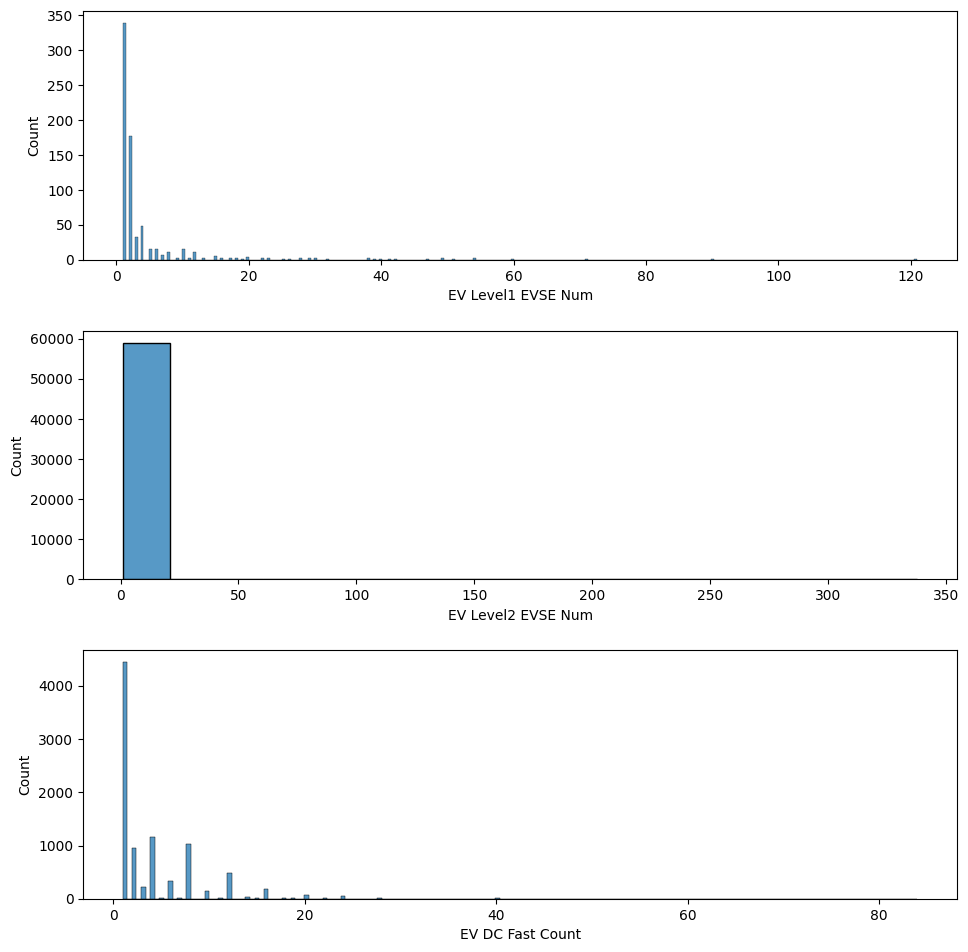

In [40]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
fig.tight_layout(pad=3.0)

sns.histplot(dataset_df['EV Level1 EVSE Num'], ax=ax[0])
sns.histplot(dataset_df['EV Level2 EVSE Num'], ax=ax[1])
sns.histplot(dataset_df['EV DC Fast Count'], ax=ax[2])

Since the data is obviously skewed right. It is reasonable to fill the missing values with zero. 

In [41]:
dataset_df['EV Level1 EVSE Num'].fillna(0, inplace=True)
dataset_df['EV Level2 EVSE Num'].fillna(0, inplace=True)
dataset_df['EV DC Fast Count'].fillna(0, inplace=True)

In [42]:
print('Sample data: ', dataset_df['Cards Accepted'].value_counts().index[0])

Sample data:  A D Debit M V


We convert this attribute to the number of payment methods supported.

In [43]:
dataset_df['Cards Accepted Num'] = dataset_df['Cards Accepted'].apply(lambda x: len(x.split(' ')) if type(x) == str else 0)
dataset_df.drop('Cards Accepted', axis=1, inplace=True)
    

In [44]:
dataset_df['EV Connector Types Num'] = dataset_df['EV Connector Types'].apply(lambda x: len(x.split(' ')) if type(x) == str else 0)
dataset_df.drop('EV Connector Types', axis=1, inplace=True)

The EV Networks attribute comes in a similar format. However, because one station can only have a single EV network, we convert this attribute to encoded integers.

In [45]:
ev_networks_list = ['ChargePoint Network',
                    'Non-Networked',
                    'Blink Network',
                    'Tesla',
                    'Volta',
                    'EV Connect',
                    'SHELL_RECHARGE',
                    'eVgo Network',
                    'Electrify America',
                    'AMPUP',
                    'FLO',
                    'RIVIAN',
                    'LIVINGSTON', 
                    ]

In [46]:
dataset_df['Network Enum'] = dataset_df['EV Network'].apply(lambda x: ev_networks_list.index(x) + 1 if x in ev_networks_list else 0)
dataset_df.drop('EV Network', axis=1, inplace=True)

The other categorical features are easier to play with, we can simply use one-hot encoding to convert them into numerical features.

In [47]:
owner_type_list = dataset_df['Owner Type Code'].value_counts().index[:10].to_list()
dataset_df['Owner Type Code Enum'] = dataset_df['Owner Type Code'].apply(lambda x: owner_type_list.index(x) + 1 if x in owner_type_list else 0)
dataset_df.drop('Owner Type Code', axis=1, inplace=True)

In [48]:
dataset_df['EV On-Site Renewable Source'].value_counts()

EV On-Site Renewable Source
SOLAR         252
NONE          115
WIND           32
HYDRO          14
WASTEWATER      3
Name: count, dtype: int64

In [49]:
dataset_df['EV On-Site Renewable Source'] = dataset_df['EV On-Site Renewable Source'].apply(lambda x: 1 if x == 'SOLAR' else 0)

In [50]:
dataset_df['Maximum Vehicle Class'].value_counts()

Maximum Vehicle Class
LD    9994
MD     297
HD      68
Name: count, dtype: int64

In [51]:
def map(x):
    if x == 'LD':
        return 1
    elif x == 'MD':
        return 2
    elif x == 'HD':
        return 3
    else:
        return 0

dataset_df['Maximum Vehicle Class Enum'] = dataset_df['Maximum Vehicle Class'].apply(map)
dataset_df.drop('Maximum Vehicle Class', axis=1, inplace=True)

In [52]:
facilities = dataset_df['Facility Type'].value_counts()[:10].index.to_list()
dataset_df['Facility Type Enum'] = dataset_df['Facility Type'].apply(lambda x: facilities.index(x) + 1 if x in facilities else 0)
dataset_df.drop('Facility Type', axis=1, inplace=True)

The preprocessing of the data is done. We can now move on to the next step.

In [53]:
dataset_df.head()

,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,Restricted Access,EV On-Site Renewable Source,EV Workplace Charging,Latitude,Longitude,Park Pricing,Electric Pricing,Cards Accepted Num,EV Connector Types Num,Network Enum,Owner Type Code Enum,Maximum Vehicle Class Enum,Facility Type Enum
0,0.0,57.0,2.0,0,0,1,34.248319,-118.387971,0.0,0.0,0,3,7,2,0,9
1,0.0,4.0,0.0,0,0,1,34.052542,-118.448504,0.0,0.0,0,1,2,2,0,9
2,0.0,7.0,0.0,0,0,0,34.040539,-118.271387,0.0,0.0,0,1,2,1,1,0
3,0.0,338.0,12.0,0,0,1,34.059133,-118.248589,0.0,0.0,0,3,2,2,1,9
4,0.0,19.0,1.0,0,0,1,33.759802,-118.096665,0.0,0.0,0,3,2,2,0,9


Output the data to a csv file for future use.

In [54]:
dataset_df.to_csv('../data/processed_nrel.csv', index=False, encoding='utf-8')